In [1]:
from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from gensim.models import Word2Vec

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2021)
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

url = './example-question-dataset-master/'

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\uyent\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\uyent\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
thoughts = pd.read_csv(url+ 'thoughts.csv')
thoughts.head()

,id,respondent_id,text
0,0,17,It's easy to use and very heavily adopted by o...
1,1,38,Easy access is just about the only thing.
2,2,23,youtube makes it really easy to see what kind ...
3,3,5,Being able to mute/block people. It helps keep...
4,4,25,Being able to share content


In [4]:
agreements = pd.read_csv(url + 'agreements.csv')
agreements.head()

,respondent_id,thought_id,label
0,32,7,Disagree
1,37,3,Agree
2,37,1,Disagree
3,37,14,Disagree
4,37,19,Disagree


In [5]:
binary_choices = pd.read_csv(url + 'binary_choices.csv')
binary_choices.head()

,respondent_id,thought_a_id,thought_b_id,label
0,32,20,14,A
1,29,19,21,A
2,37,6,19,A
3,32,35,5,A
4,37,8,6,B


# Topic Modeling

In [6]:
data = thoughts.text.values.tolist()


# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

## Tokenize words and Clean-up text

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[26:27])

[['ability', 'to', 'see', 'updates', 'in', 'real', 'time', 'ability', 'to', 'keep', 'up', 'with', 'friends', 'family']]


## Creating Bigram (and Trigram Models)

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=4, threshold=7) # higher threshold fewer phrases. set this low since out samplesize is snall
# trigram = gensim.models.Phrases(bigram[data_words], threshold=6)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(bigram_mod[data_words[0]])

['its', 'easy', 'to', 'use', 'and', 'very', 'heavily', 'adopted', 'by', 'other', 'people']


## Remove Stopwords, make Bigrams and Lemmatize

In [9]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['feature'])

In [10]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# def make_trigrams(texts):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en_core_web_sm' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:15])

[['easy', 'use', 'heavily', 'adopt', 'people'], ['easy', 'access', 'thing'], ['make', 'really', 'easy', 'see', 'kind', 'audience', 'video', 'people', 'access'], ['able', 'mute', 'block', 'people', 'help', 'keep', 'feed', 'clean'], ['able', 'share', 'content'], ['ease', 'use', 'popularity', 'much'], ['block'], ['useless'], ['love', 'see', 'people', 'picture', 'able', 'communicate', 'easily'], ['ability', 'set', 'profile', 'private'], ['easy', 'voice', 'video', 'easy', 'payment', 'option', 'send', 'receive', 'money', 'lot', 'control', 'control'], ['honest', 'stand', 'adequate'], ['able', 'unfollow', 'idiot', 'repeatedly', 'think', 'send'], ['mute', 'people', 'day', 'facebook'], []]


## Create the Dictionary and Corpus needed for Topic Modeling

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])
# id2word[0]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


# LDA MODEL

In [13]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=64,
                                           update_every=1,
                                           chunksize=5,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [14]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.097*"want" + 0.088*"option" + 0.087*"love" + 0.085*"youtube" + '
  '0.085*"watch" + 0.085*"many" + 0.030*"ability" + 0.028*"know" + '
  '0.016*"enjoy" + 0.014*"time"'),
 (1,
  '0.076*"post" + 0.056*"easy" + 0.050*"people" + 0.049*"see" + 0.032*"video" '
  '+ 0.027*"default" + 0.027*"recent" + 0.027*"hate" + 0.022*"late" + '
  '0.022*"follow"'),
 (2,
  '0.077*"family" + 0.075*"friend" + 0.055*"see" + 0.051*"picture" + '
  '0.047*"easily" + 0.036*"live" + 0.035*"content" + 0.032*"post" + '
  '0.023*"share" + 0.019*"filter"'),
 (3,
  '0.065*"keep" + 0.055*"people" + 0.037*"weird" + 0.030*"contact" + '
  '0.029*"use" + 0.028*"new" + 0.027*"time" + 0.024*"touch" + 0.020*"update" + '
  '0.020*"lot"')]


In [15]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.548230979835623

Coherence Score:  0.44952178247943614


In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word,mds = 'pcoa')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.101632  0.137939       1        1  31.737880
3     -0.063930 -0.151805       2        1  28.633175
1     -0.068500 -0.003532       3        1  20.629170
0      0.234062  0.017398       4        1  18.999775, topic_info=        Term      Freq     Total Category  logprob  loglift
54      want  4.000000  4.000000  Default  30.0000  30.0000
37    option  4.000000  4.000000  Default  29.0000  29.0000
28      love  4.000000  4.000000  Default  28.0000  28.0000
129  youtube  4.000000  4.000000  Default  27.0000  27.0000
128    watch  4.000000  4.000000  Default  26.0000  26.0000
..       ...       ...       ...      ...      ...      ...
33       set  0.195842  0.731613   Topic4  -5.4034   0.3428
32   profile  0.195842  0.731613   Topic4  -5.4034   0.3428
31   private  0.195842  0.731613   Topic4  -5.4034   0.3428
25   useless  0.195838  0.731610   Topic4  -5.4034   0.3428
79      time  0.593888  2.743440   Topic4  -4.2940   0.1305

[163 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
30        4  0.492128  ability
13        1  0.453887     able
13        2  0.453887     able
80        1  0.756800   accept
5         3  1.036442   access
...     ...       ...      ...
54        4  0.842508     want
128       4  0.945525    watch
120       2  0.694906    weird
62        1  0.964699     well
129       4  0.945525  youtube

[103 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1])

# LDA Mallet

The Coherence score here is a little bit loe so try LDA Mallet to improve the performance

In [17]:

import os
from gensim.models.wrappers import LdaMallet

# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

os.environ.update({'MALLET_HOME': r'C:/new_mallet/mallet-2.0.8/'})
mallet_path = 'C:/new_mallet/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=6, id2word=id2word, random_seed=2021)

In [18]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('update', 0.09523809523809523),
   ('weird', 0.09523809523809523),
   ('literature', 0.047619047619047616),
   ('dominant', 0.047619047619047616),
   ('find', 0.047619047619047616),
   ('feed', 0.047619047619047616),
   ('receive', 0.047619047619047616),
   ('hobbie', 0.047619047619047616),
   ('touch', 0.047619047619047616),
   ('love', 0.047619047619047616)]),
 (1,
  [('people', 0.4),
   ('content', 0.08),
   ('useless', 0.04),
   ('idiot', 0.04),
   ('request', 0.04),
   ('hot', 0.04),
   ('russian', 0.04),
   ('option', 0.04),
   ('stand', 0.04),
   ('repeatedly', 0.04)]),
 (2,
  [('friend', 0.09090909090909091),
   ('share', 0.09090909090909091),
   ('feature', 0.06060606060606061),
   ('lot', 0.06060606060606061),
   ('ability', 0.06060606060606061),
   ('access', 0.06060606060606061),
   ('live', 0.06060606060606061),
   ('option', 0.030303030303030304),
   ('upvote', 0.030303030303030304),
   ('communicate', 0.030303030303030304)]),
 (3,
  [('easy', 0.26666666666666666

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, random_seed=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=10, step=1)


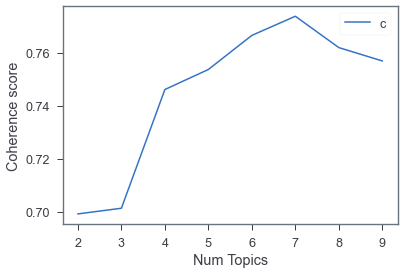

In [21]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6992
Num Topics = 3  has Coherence Value of 0.7013
Num Topics = 4  has Coherence Value of 0.7462
Num Topics = 5  has Coherence Value of 0.7538
Num Topics = 6  has Coherence Value of 0.7667
Num Topics = 7  has Coherence Value of 0.774
Num Topics = 8  has Coherence Value of 0.7621
Num Topics = 9  has Coherence Value of 0.757


In [23]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.073*"lot" + 0.073*"time" + 0.049*"ability" + 0.049*"feature" + '
  '0.049*"control" + 0.024*"photo" + 0.024*"private" + 0.024*"love" + '
  '0.024*"popularity" + 0.024*"communicate"'),
 (1,
  '0.200*"people" + 0.160*"friend" + 0.140*"family" + 0.040*"ability" + '
  '0.040*"send" + 0.040*"access" + 0.040*"video" + 0.020*"touch" + '
  '0.020*"convenience" + 0.020*"upvote"'),
 (2,
  '0.102*"easily" + 0.102*"picture" + 0.082*"post" + 0.061*"share" + '
  '0.041*"weird" + 0.020*"recent" + 0.020*"fix" + 0.020*"bug" + 0.020*"hate" + '
  '0.020*"follow"'),
 (3,
  '0.211*"easy" + 0.079*"content" + 0.079*"post" + 0.053*"update" + '
  '0.053*"live" + 0.053*"block" + 0.026*"instagram" + 0.026*"care" + '
  '0.026*"communicate" + 0.026*"mute"')]


In [24]:
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
vis

C:\Users\uyent\capstone\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\Users\uyent\capstone\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\Users\uyent\capstone\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.332010  0.197791       1        1  25.371454
2     -0.289050  0.243056       2        1  25.139882
0      0.156018 -0.234178       3        1  24.857266
3     -0.198978 -0.206670       4        1  24.631398, topic_info=        Term  Freq      Total Category  logprob  loglift
1       easy  11.0  11.000000  Default     30.0     30.0
3     people  11.0  11.000000  Default     29.0     29.0
59    friend   9.0   9.000000  Default     28.0     28.0
58    family   8.0   8.000000  Default     27.0     27.0
27    easily   5.0   5.000000  Default     26.0     26.0
..       ...   ...        ...      ...      ...      ...
49       day   0.0   2.563274   Topic4     -inf     -inf
48  unfollow   0.0   1.388369   Topic4     -inf     -inf
40      send   0.0   2.324025   Topic4     -inf     -inf
52   feature   0.0   2.776738   Topic4     -inf     -inf
45     idiot   0.0   1.162013   Topic4     -inf     -inf

[175 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
30        1  0.392098   ability
30        3  0.588147   ability
80        3  0.720269    accept
5         1  0.860576    access
42        4  0.673688  adequate
...     ...       ...       ...
12        3  0.269368     video
41        3  0.720269     voice
128       3  0.720269     watch
120       2  0.851133     weird
129       4  0.673688   youtube

[117 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4])

In [25]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.2685,"people, friend, family, ability, send, access,...",Its easy to use and very heavily adopted by ot...
1,1,2.0,0.2547,"easily, picture, post, share, weird, recent, f...",Easy access is just about the only thing.
2,2,1.0,0.2836,"people, friend, family, ability, send, access,...",youtube makes it really easy to see what kind ...
3,3,3.0,0.2737,"easy, content, post, update, live, block, inst...",Being able to mute/block people. It helps keep...
4,4,2.0,0.2596,"easily, picture, post, share, weird, recent, f...",Being able to share content


In [26]:
df_dominant_topic['topic_id'] = df_dominant_topic['Dominant_Topic']

In [27]:
df_dominant_topic['topic_id'] = df_dominant_topic['topic_id'].replace([0.0], 'Ease of Connectivity')
df_dominant_topic['topic_id'] = df_dominant_topic['topic_id'].replace([1.0], 'Easy to Use')
df_dominant_topic['topic_id'] = df_dominant_topic['topic_id'].replace([2.0], 'Easy To Access')
df_dominant_topic['topic_id'] = df_dominant_topic['topic_id'].replace([3.0], 'Show Relevant Contents')
# df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].replace([3.0], 'Easy to Access')
# df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].replace([3.0], 'Experimental Medicine')

In [28]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,topic_id
0,0,1.0,0.2685,"people, friend, family, ability, send, access,...",Its easy to use and very heavily adopted by ot...,Easy to Use
1,1,2.0,0.2547,"easily, picture, post, share, weird, recent, f...",Easy access is just about the only thing.,Easy To Access
2,2,1.0,0.2836,"people, friend, family, ability, send, access,...",youtube makes it really easy to see what kind ...,Easy to Use
3,3,3.0,0.2737,"easy, content, post, update, live, block, inst...",Being able to mute/block people. It helps keep...,Show Relevant Contents
4,4,2.0,0.2596,"easily, picture, post, share, weird, recent, f...",Being able to share content,Easy To Access
5,5,0.0,0.2618,"lot, time, ability, feature, control, photo, p...","Ease of use, popularity. There is much that yo...",Ease of Connectivity
6,6,3.0,0.2647,"easy, content, post, update, live, block, inst...",Blocking,Show Relevant Contents
7,7,0.0,0.2647,"lot, time, ability, feature, control, photo, p...",Few. Most of it is useless,Ease of Connectivity
8,8,2.0,0.2737,"easily, picture, post, share, weird, recent, f...",I love seeing other peoples pictures and being...,Easy To Access
9,9,0.0,0.2809,"lot, time, ability, feature, control, photo, p...",The ability to set my profile to private.,Ease of Connectivity


In [30]:
df_dominant_topic.to_csv(url + 'thoughts_topics.csv', index=False, header=True)